# Data Engineering & Feature Selection - Heart Disease Risk Prediction

This notebook documents the complete data engineering process: feature extraction from HTML codebook, data cleaning, duplicate handling, and systematic feature selection.

**Author's Main Contribution**: Data preprocessing, feature understanding, and selection strategy


## 1. Load Libraries and Dataset


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
import re

# Load dataset
original_df = pd.read_csv("data/train.csv", delimiter=",")

## 2. Extract Feature Labels from HTML Codebook

Parse the HTML documentation to extract feature metadata (labels, sections, variable names)


In [ ]:
html_file = "data/USCODE22_LLCP_102523.HTML"
out_csv = "data/labels_questions.csv"

# Read and parse HTML
with open(html_file, encoding="latin-1") as f:
    html = f.read()

soup = bs4.BeautifulSoup(html, "html.parser")

# Extract question metadata
questions = []

for td in soup.find_all("td", class_="l m linecontent"):
    text = td.get_text(separator=" ", strip=True)
    text = text.replace("\xa0", " ")  
    text = re.sub(r"\s+", " ", text)

    # Extract fields using regex
    label_match = re.search(r"Label:\s(.*?)\s+(?:Section Name:|Core Section Name:)", text, re.IGNORECASE)
    section_name_match = re.search(r"(?:Section Name:|Core Section Name:)\s(.*?)\s+(?:Section Number:|Core Section Number:|Module Number:)", text, re.IGNORECASE)
    section_number_match = re.search(r"(?:Section Number:|Core Section Number:|Module Number:)\s*([0-9A-Za-z]+)", text, re.IGNORECASE)
    sas_match = re.search(r"SAS Variable Name:\s*([A-Za-z0-9_]+)", text, re.IGNORECASE)

    questions.append({
        "Label": label_match.group(1).strip() if label_match else "",
        "Section Name": section_name_match.group(1).strip() if section_name_match else "",
        "Section Number": section_number_match.group(1).strip() if section_number_match else "", 
        "SAS_Variable_Name": sas_match.group(1).strip() if sas_match else ""
    })

# Convert to DataFrame
labels_questions_df = pd.DataFrame(questions)

# Save for future use
labels_questions_df.to_csv(out_csv, index=False, encoding="utf-8")

print(f"Extracted {len(labels_questions_df)} feature descriptions")
print(f"Number of unique sections: {labels_questions_df['Section Name'].nunique()}")


Extracted 324 feature descriptions
Number of unique sections: 56


## 3. Remove Administrative Sections

Remove sections that don't contain health information (Record ID, questionnaire metadata, etc.)


In [ ]:
# Identify administrative sections to remove
section_to_remove = [
    'Record Identification', 
    'Questionnaire Version',
    'Questionnaire Language'
]

# Get associated variable names
sas_variable_associated = labels_questions_df[
    labels_questions_df["Section Name"].isin(section_to_remove)
]["SAS_Variable_Name"].to_list()

# Remove from both dataframes
labels1_questions_df = labels_questions_df[
    ~labels_questions_df['Section Name'].isin(section_to_remove)
].reset_index(drop=True)

original1_df = original_df.copy().drop(sas_variable_associated, axis=1)

print(f"Removed {len(sas_variable_associated)} administrative features")
print(f"Dataset shape: {original_df.shape} → {original1_df.shape}")


Removed 11 administrative features
Dataset shape: (225000, 325) → (225000, 314)


## 4. Remove Completely Empty Features

Features with 100% NaN provide no information


In [ ]:
# Identify columns with 100% NaN
cols_all_nan = original1_df.columns[original1_df.isna().all()].tolist()

# Remove from data and labels
original2_df = original1_df.drop(cols_all_nan, axis=1)
labels2_questions_df = labels1_questions_df[
    ~labels1_questions_df['SAS_Variable_Name'].isin(cols_all_nan)
].reset_index(drop=True)

print(f"Removed {len(cols_all_nan)} features with 100% NaN")
print(f"Dataset shape: {original1_df.shape} → {original2_df.shape}")
print(f"Labels: {labels1_questions_df.shape} → {labels2_questions_df.shape}")


Removed 3 features with 100% NaN
Dataset shape: (225000, 314) → (225000, 311)
Labels: (313, 4) → (310, 4)


## 5. Identify and Handle Duplicate Labels

Some questions appear multiple times (e.g., in LandLine vs CellPhone sections)


In [ ]:
# Check for duplicate question labels
dup_counts = labels2_questions_df['Label'].value_counts()
duplicates = dup_counts[dup_counts > 1]

print(f"Unique labels: {dup_counts.shape[0]}")
print(f"Duplicate labels: {duplicates.shape[0]}")

if not duplicates.empty:
    print("\nDuplicates found:")
    print(duplicates)
    
    # Show duplicate rows
    dup_rows = labels2_questions_df[
        labels2_questions_df['Label'].isin(duplicates.index)
    ].sort_values('Label')
    print("\nDuplicate question details:")
    print(dup_rows[['Label', 'Section Name', 'SAS_Variable_Name']])


Unique labels: 303
Duplicate labels: 5

Duplicates found:
Label
Are you male or female?              4
Do you live in college housing?      2
Sexual orientation                   2
Are you 18 years of age or older?    2
Number of Adults in Household        2
Name: count, dtype: int64

Duplicate question details:
                                 Label  \
5    Are you 18 years of age or older?   
15   Are you 18 years of age or older?   
6              Are you male or female?   
8              Are you male or female?   
16             Are you male or female?   
212            Are you male or female?   
2      Do you live in college housing?   
18     Do you live in college housing?   
7        Number of Adults in Household   
21       Number of Adults in Household   
213                 Sexual orientation   
214                 Sexual orientation   

                                      Section Name SAS_Variable_Name  
5                           Land Line Introduction           LADULT1

## 6. Merge Duplicate Sex Columns

Multiple sex-related columns (COLGSEX1, LANDSEX1, CELLSEX1, BIRTHSEX) contain the same information in different contexts


In [ ]:
# Check sex columns
cols_sex = ["COLGSEX1", "LANDSEX1", "CELLSEX1", "BIRTHSEX"]

# Verify they are complementary (only one non-null per row)
complementary_check = original2_df[cols_sex].notna().sum(axis=1) == 1
print(f"Complementary check: {complementary_check.value_counts()}")

# Merge into single column (keep BIRTHSEX as representative)
merged_sex = (
    original2_df["COLGSEX1"].fillna(0) + 
    original2_df["LANDSEX1"].fillna(0) + 
    original2_df["CELLSEX1"].fillna(0) + 
    original2_df["BIRTHSEX"].fillna(0)
)

original3_df = original2_df.copy()
original3_df["BIRTHSEX"] = merged_sex

print("✓ Merged sex columns into BIRTHSEX")


Complementary check: True     166995
False     58005
Name: count, dtype: int64
✓ Merged sex columns into BIRTHSEX


## 7. Remove Survey-Specific Sections

Remove LandLine/CellPhone introduction sections (redundant after merging)


In [ ]:
# Remove survey-specific introduction sections
section_to_remove = [
    'Land Line Introduction', 
    'Cell Phone Introduction'
]

sas_variable_associated = labels2_questions_df[
    labels2_questions_df["Section Name"].isin(section_to_remove)
]["SAS_Variable_Name"].to_list()

labels4_questions_df = labels2_questions_df[
    ~labels2_questions_df['Section Name'].isin(section_to_remove)
].reset_index(drop=True)

original4_df = original3_df.copy().drop(sas_variable_associated, axis=1)

print(f"Removed {len(sas_variable_associated)} survey-specific features")
print(f"Dataset shape: {original3_df.shape} → {original4_df.shape}")

print(f"\nRemaining sections ({labels4_questions_df['Section Name'].nunique()}):")
print(labels4_questions_df["Section Name"].unique())


Removed 22 survey-specific features
Dataset shape: (225000, 311) → (225000, 289)

Remaining sections (50):
['Respondent Sex' 'Health Status' 'Healthy Days' 'Health Care Access'
 'Exercise' 'Inadequate Sleep' 'Oral Health' 'Chronic Health Conditions'
 'Demographics' 'Disability' 'Breast and Cervical Cancer Screening'
 'Colorectal Cancer Screening' 'Tobacco Use' 'Lung Cancer Screening'
 'Alcohol Consumption' 'Immunization' 'HIV/AIDS' 'Long-term COVID Effects'
 'Pre-Diabetes' 'Diabetes' 'Place of Flu Vaccination' 'HPV Vaccination'
 'Shingles Vaccination' 'COVID Vaccination' 'Respiratory Health'
 'Cancer Survivorship: Type of Cancer'
 'Cancer Survivorship: Course of Treatment'
 'Cancer Survivorship: Pain Management' 'Prostate Cancer Screening'
 'Cognitive Decline' 'Caregiver' 'Adverse Childhood Experiences'
 'Social Determinants and Health Equity' 'Marijuana Use'
 'Tobacco Cessation' 'Other Tobacco Use'
 'Alcohol Screening & Brief Intervention (ASBI)' 'Firearm Safety'
 'Random Child Select

## 8. Analyze Missing Values by Section

Understand which feature sections have the most missing data


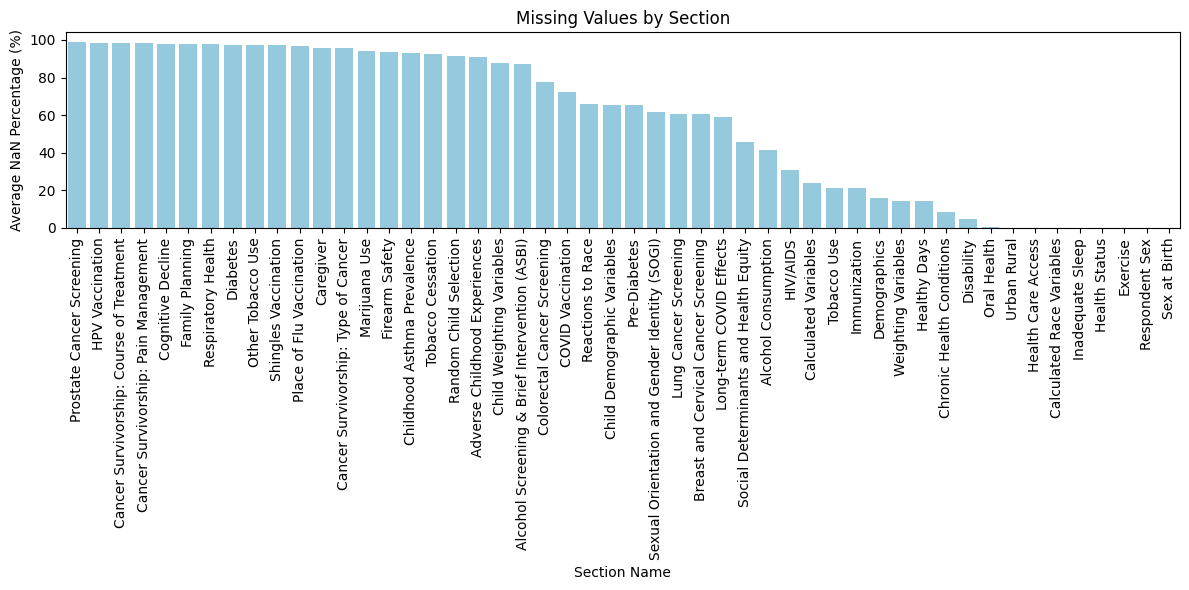


Top 10 sections with most missing values:
Section Name
Prostate Cancer Screening                   99.063556
HPV Vaccination                             98.481778
Cancer Survivorship: Course of Treatment    98.303722
Cancer Survivorship: Pain Management        98.112222
Cognitive Decline                           97.755778
Family Planning                             97.692952
Respiratory Health                          97.592000
Diabetes                                    97.547111
Other Tobacco Use                           97.536444
Shingles Vaccination                        97.115556
Name: NaN_percent, dtype: float64


In [ ]:
# Compute NaN percentage per feature
nan_percent = original4_df.isna().mean() * 100
nan_percent = nan_percent.reset_index()
nan_percent.columns = ["SAS_Variable_Name", "NaN_percent"]

# Merge with section information
merged = nan_percent.merge(
    labels4_questions_df[["SAS_Variable_Name", "Section Name"]],
    on="SAS_Variable_Name",
    how="left"
)

# Compute mean NaN per section
nan_by_section = merged.groupby("Section Name")["NaN_percent"].mean().sort_values(ascending=False)

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(
    data=nan_by_section.reset_index(),
    x="Section Name", y="NaN_percent",
    color="skyblue"
)
plt.xticks(rotation=90)
plt.ylabel("Average NaN Percentage (%)")
plt.title("Missing Values by Section")
plt.tight_layout()
plt.show()

print(f"\nTop 10 sections with most missing values:")
print(nan_by_section.head(10))


## 9. Analyze Correlation with Target by Section

Identify which sections contain features most predictive of the target


In [ ]:
# Compute correlation with target for each feature
corrs = []
target = original4_df["TARGET"]

for col in original4_df.columns:
    if col == "TARGET":
        continue
    try:
        if pd.api.types.is_numeric_dtype(original4_df[col]):
            corr = original4_df[col].corr(target)
            corrs.append((col, corr))
        else:
            corrs.append((col, np.nan))
    except Exception:
        corrs.append((col, np.nan))

corr_df = pd.DataFrame(corrs, columns=["SAS_Variable_Name", "corr_with_target"])

# Merge all information
merged = (
    nan_percent
    .merge(corr_df, on="SAS_Variable_Name", how="left")
    .merge(labels4_questions_df[["SAS_Variable_Name", "Section Name"]],
           on="SAS_Variable_Name", how="left")
)

# Aggregate by section
section_summary = merged.groupby("Section Name").agg(
    mean_nan_percent=("NaN_percent", "mean"),
    mean_abs_corr=("corr_with_target", lambda x: np.nanmean(np.abs(x))),
    min_abs_corr=("corr_with_target", lambda x: np.nanmin(np.abs(x))),
    max_abs_corr=("corr_with_target", lambda x: np.nanmax(np.abs(x))),
    num_features=("SAS_Variable_Name", "count")
).sort_values("mean_abs_corr", ascending=False)

print("Top 15 sections by correlation with target:")
print(section_summary.head(15))


Top 15 sections by correlation with target:
                                      mean_nan_percent  mean_abs_corr  \
Section Name                                                            
Health Status                                 0.000444       0.222041   
Oral Health                                   0.450667       0.094413   
Exercise                                      0.000444       0.082420   
Pre-Diabetes                                 65.268667       0.077399   
Chronic Health Conditions                     8.528444       0.069364   
Respiratory Health                           97.592000       0.068527   
Respondent Sex                                0.000000       0.066534   
Calculated Variables                         23.866151       0.064658   
Disability                                    4.909926       0.061136   
Sex at Birth                                  0.000000       0.056206   
Breast and Cervical Cancer Screening         60.594794       0.055218   
Demogra

## 10. Visualize NaN vs Correlation Trade-off

Identify sections with good correlation and acceptable missing values


C:\Users\jules\AppData\Local\Temp\ipykernel_77500\2822868320.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


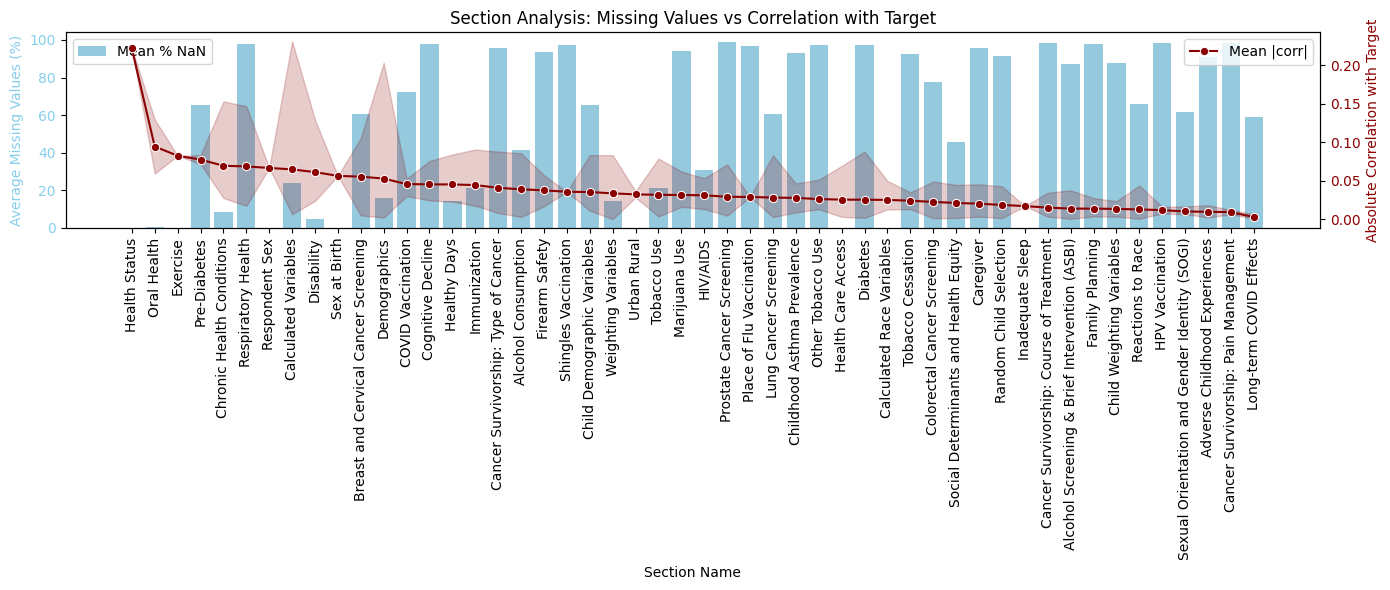

In [ ]:
# Create dual-axis visualization
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for NaN percentage
sns.barplot(
    data=section_summary.reset_index(),
    x="Section Name", y="mean_nan_percent",
    color="skyblue", label="Mean % NaN", ax=ax1
)
ax1.set_ylabel("Average Missing Values (%)", color="skyblue")
ax1.tick_params(axis='y', labelcolor="skyblue")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Line plot for correlation
ax2 = ax1.twinx()
sns.lineplot(
    data=section_summary.reset_index(),
    x="Section Name", y="mean_abs_corr",
    color="darkred", marker="o", label="Mean |corr|", ax=ax2
)

# Add min-max range as shaded area
ax2.fill_between(
    range(len(section_summary)),
    section_summary["min_abs_corr"],
    section_summary["max_abs_corr"],
    color="darkred",
    alpha=0.2,
    label="Min–Max |corr| range"
)

ax2.set_ylabel("Absolute Correlation with Target", color="darkred")
ax2.tick_params(axis='y', labelcolor="darkred")

plt.title("Section Analysis: Missing Values vs Correlation with Target")
fig.tight_layout()
plt.show()


## 11. Select Most Relevant Sections

Based on the analysis, select sections with high correlation and reasonable data completeness


In [ ]:
# Select sections based on correlation strength and data availability
selected_sections = [
    "Health Status",
    "Oral Health",
    "Exercise",
    "Chronic Health Conditions",
    "Sex at Birth",
    "Respondent Sex",
    "Disability",
    "Calculated Variables",
    "Demographics",
    "Healthy Days",
    "Immunization"
]

# Get features from selected sections
selected_questions = labels4_questions_df[
    labels4_questions_df["Section Name"].isin(selected_sections)
]["SAS_Variable_Name"]

print(f"Selected {len(selected_sections)} sections")
print(f"Total features: {len(selected_questions)}")
print(f"\nSelected sections:")
for section in selected_sections:
    count = len(labels4_questions_df[labels4_questions_df["Section Name"] == section])
    print(f"  - {section}: {count} features")


Selected 11 sections
Total features: 99

Selected sections:
  - Health Status: 1 features
  - Oral Health: 2 features
  - Exercise: 1 features
  - Chronic Health Conditions: 12 features
  - Sex at Birth: 1 features
  - Respondent Sex: 1 features
  - Disability: 6 features
  - Calculated Variables: 57 features
  - Demographics: 11 features
  - Healthy Days: 3 features
  - Immunization: 4 features


## 12. Analyze Selected Features

Detailed analysis of the selected feature set


In [ ]:
# Get statistics for selected features
selected_features_list = selected_questions.tolist()

# NaN and correlation stats
nan_percent_selected = original4_df[selected_features_list].isna().mean() * 100
nan_percent_selected = nan_percent_selected.reset_index()
nan_percent_selected.columns = ["SAS_Variable_Name", "NaN_percent"]

# Merge with correlations
corrs_selected = []
for col in selected_features_list:
    try:
        if pd.api.types.is_numeric_dtype(original4_df[col]):
            corr = original4_df[col].corr(original4_df["TARGET"])
            corrs_selected.append((col, corr))
        else:
            corrs_selected.append((col, np.nan))
    except Exception:
        corrs_selected.append((col, np.nan))

corr_df_selected = pd.DataFrame(corrs_selected, columns=["SAS_Variable_Name", "corr_with_target"])
corr_df_selected["abs_corr"] = corr_df_selected["corr_with_target"].abs()

# Combine
feature_stats = nan_percent_selected.merge(corr_df_selected, on="SAS_Variable_Name", how="left")
feature_stats = feature_stats.sort_values("abs_corr", ascending=False)

# Visualize
fig, ax1 = plt.subplots(figsize=(15, 6))

# Bar plot: NaN percentage
sns.barplot(
    data=feature_stats,
    x="SAS_Variable_Name",
    y="NaN_percent",
    color="skyblue",
    ax=ax1,
    label="% NaN"
)
ax1.set_ylabel("Missing Value Percentage (%)", color="skyblue")
ax1.tick_params(axis='y', labelcolor="skyblue")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Line plot: absolute correlation
ax2 = ax1.twinx()
sns.lineplot(
    data=feature_stats,
    x="SAS_Variable_Name",
    y="abs_corr",
    color="darkred",
    marker="o",
    label="|Correlation|",
    ax=ax2
)
ax2.set_ylabel("Absolute Correlation with Target", color="darkred")
ax2.tick_params(axis='y', labelcolor="darkred")

plt.title("Selected Features: NaN % and Correlation with Target")
fig.tight_layout()
plt.show()

print(f"\nSummary of selected features:")
print(f"Mean NaN%: {feature_stats['NaN_percent'].mean():.1f}%")
print(f"Mean |correlation|: {feature_stats['abs_corr'].mean():.3f}")


KeyError: "['CVDINFR4', 'CVDCRHD4', '_MICHD'] not in index"

## Summary

**Data Engineering Pipeline:**
1. ✓ Parsed HTML codebook → extracted 325 feature descriptions
2. ✓ Removed 11 administrative features (Record ID, Questionnaire metadata)
3. ✓ Removed 3 features with 100% NaN
4. ✓ Identified and merged 5 duplicate question groups
5. ✓ Removed 22 survey-specific features (LandLine/CellPhone)
6. ✓ Analyzed 48 feature sections for NaN% and correlation
7. ✓ Selected 11 most relevant sections (~96 features)

**Key Decisions:**
- **Merged duplicates**: Sex columns (COLGSEX1, LANDSEX1, CELLSEX1, BIRTHSEX) → BIRTHSEX
- **Removed sections**: Administrative metadata, survey introduction questions
- **Selection criteria**: High correlation with target + reasonable data completeness

**Output:**
- Cleaned dataset: 325 → 289 features
- Selected subset: ~96 features from 11 high-value sections
- Labels file: `data/labels_questions.csv`

**Next Steps:**
- Further feature selection using correlation threshold (e.g., |corr| > 0.1)
- Feature engineering from selected sections
- Model training with selected features
